In [1]:
import pandas as pd 
import numpy as np
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

spanish_lexicon_path = "NRC-Emotion-Lexicon/OneFilePerLanguage/Spanish-NRC-EmoLex.txt"
spanish_dataset_path = "dataset_oppositional/dataset_es_train.json"

spanish_lexicon_df = pd.read_csv(spanish_lexicon_path, sep="\t")
spanish_dataset_df = pd.read_json(spanish_dataset_path)
spanish_dataset_df.head()

,id,text,category,annotations,spacy_tokens
0,2807,Fallo en Matrix 08/02/2022 Hoy el señor Joan R...,CRITICAL,[{'span_text': 'el señor Joan Ramón Laporte Ro...,WyJGYWxsbyIsICJlbiIsICJNYXRyaXgiLCAiMDgvMDIvMj...
1,3054,Siento ya tdas las vacunas vienen contaminadas...,CRITICAL,"[{'span_text': 'mi sobrina', 'category': 'VICT...",WyJTaWVudG8iLCAieWEiLCAidGRhcyIsICJsYXMiLCAidm...
2,268,Veo que curiosamente te autoproclamados interl...,CONSPIRACY,"[{'span_text': 'todo el grupo', 'category': 'C...",WyJWZW8iLCAicXVlIiwgImN1cmlvc2FtZW50ZSIsICJ0ZS...
3,2669,[ Documental ] Vacunas : Una inyección en la o...,CRITICAL,[{'span_text': '[ Documental ] Vacunas : Una i...,WyJbIiwgIkRvY3VtZW50YWwiLCAiXSIsICJWYWN1bmFzIi...
4,3205,Una sugerencia para los que se han vacunado y ...,CONSPIRACY,[{'span_text': 'los que se han vacunado y no q...,WyJVbmEiLCAic3VnZXJlbmNpYSIsICJwYXJhIiwgImxvcy...


In [2]:
def create_emotion_vector(tokens: list, spanish_lexicon: pd.DataFrame=spanish_lexicon_df):
    rows = spanish_lexicon[spanish_lexicon["Spanish Word"].isin(tokens)][["anger", "fear", "joy", "sadness"]]
    return np.sum(rows.values, axis=0)

def tokenize_text(text: str, nlp=spacy.load('es_core_news_sm')):
    doc = nlp(text)
    # Tokenizar el texto, eliminando números, signos de puntuación, menciones y stopwords
    token_list = [token.text.lower() for token in doc 
                  if not token.is_punct 
                  and not token.is_digit 
                  and not token.text.startswith('@')
                  and token.text.lower() not in STOP_WORDS]
    
    return token_list


nlp=spacy.load('es_core_news_sm')

text_tokenized = spanish_dataset_df["text"].apply(lambda x: tokenize_text(x, nlp))

In [3]:
emotion_vectors = text_tokenized.apply(create_emotion_vector)

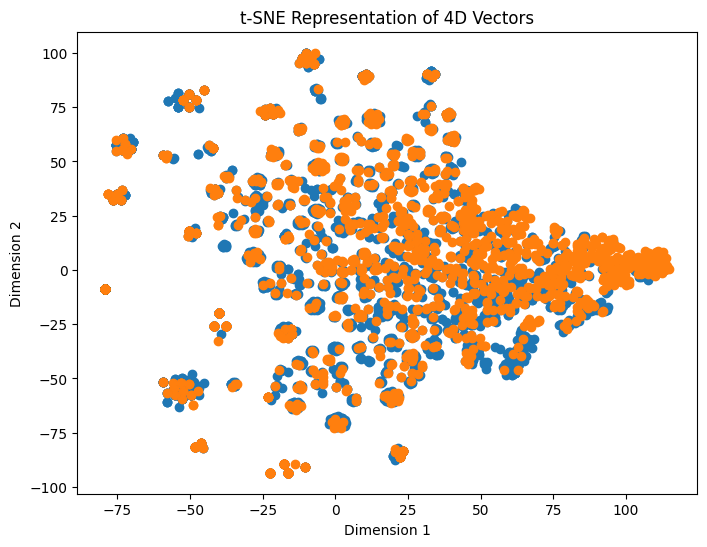

In [6]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(np.array(emotion_vectors.values.tolist()))

vectors_2d_critical = spanish_dataset_df["category"] == "CRITICAL"
vectors_2d_conspiracy = spanish_dataset_df["category"] == "CONSPIRACY"
# Plot the 2D representation
plt.figure(figsize=(8, 6))
plt.scatter(vectors_2d[vectors_2d_critical, 0], vectors_2d[vectors_2d_critical, 1])
plt.scatter(vectors_2d[vectors_2d_conspiracy, 0], vectors_2d[vectors_2d_conspiracy, 1])

plt.title('t-SNE Representation of 4D Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
